# Tutorial 11 - Representing an Image with an MLP

## Dr. David C. Schedl

This tutorial is geared towards students **experienced in programming** and aims to introduce you to **Computer Vision** techniques.

We represent a single image as MLP (we totally overfit it). 

Useful links:
* [PyTorch documentation](https://pytorch.org/docs/stable/index.html)


##### Acknowledgements
This notebook is adapted from: https://github.com/tancik/fourier-feature-networks

In [1]:
!pip install imageio-ffmpeg

import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio.v2 as imageio, cv2

# initialize the random number generator for reproducibility
torch.manual_seed(0)
np.random.seed(0)



[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: C:\Python311\python.exe -m pip install --upgrade pip


## Set up data

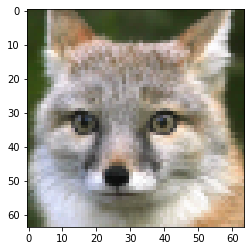

In [2]:
# Download image, take a square crop from the center
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.imread(image_url)[..., :3] / 255.
c = [img.shape[0]//2, img.shape[1]//2]
r = 256
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]
img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)

plt.imshow(img)
plt.show()

# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img]
train_data = [x_test[::2, ::2], img[::2, ::2]] # subsample the image for training

# Model and training code

Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

In [3]:

# PyTorch network definition
class Network(nn.Module):
    def __init__(self, num_layers, num_channels, num_inputs=2):
        super(Network, self).__init__()
        layers = []
        layers.append(nn.Linear(num_inputs, num_channels))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(num_channels, num_channels))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(num_channels, 3))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)



# Train model with given hyperparameters and data
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

def train_model(network_size, learning_rate, iters, train_data, test_data, input_mapping=lambda x: x):
    
    inputs, targets = train_data
    mapped_inputs = input_mapping(inputs)

    model = Network(*network_size, num_inputs=mapped_inputs.shape[-1])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_psnrs = []
    test_psnrs = []
    pred_imgs = []
    xs = []

    for i in tqdm(range(iters), desc='train iter', leave=False):
        optimizer.zero_grad()

        inputs, targets = train_data
        mapped_inputs = input_mapping(inputs)
        inputs = torch.from_numpy(mapped_inputs).float()
        targets = torch.from_numpy(targets).float()

        outputs = model(inputs)
        loss = 0.5 * torch.mean((outputs - targets) ** 2)
        loss.backward()

        optimizer.step()

        if i % 25 == 0:
            train_psnrs.append(-10 * torch.log10(2.0 * loss).item())

            test_inputs, test_target = test_data
            test_inputs = input_mapping(test_inputs)
            test_inputs = torch.from_numpy(test_inputs).float()

            test_outputs = model(test_inputs)
            test_loss = 0.5 * torch.mean((test_outputs.detach() - test_target) ** 2)
            test_psnrs.append(-10 * torch.log10(2.0 * test_loss).item())

            pred_imgs.append(test_outputs.detach().numpy())
            xs.append(i)

    return {
        'state': model.state_dict(),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'pred_imgs': np.stack(pred_imgs),
        'xs': xs,
    }


## Train the model
Let's train the model on our single image and see what happens.

In [13]:
network_size = (4, 128)
learning_rate = 1e-4
iters = 1000


outputs = {}
# Train model without any mapping
outputs['naive'] = train_model(network_size, learning_rate, iters,  train_data, test_data)

## Visualize the results

The network has learned to represent the image as a function of the input coordinates. 
Visually, however, the results are very bad. 

What is going on? 
Does training longer (`iters`) or a larger network (`network_size`) help?

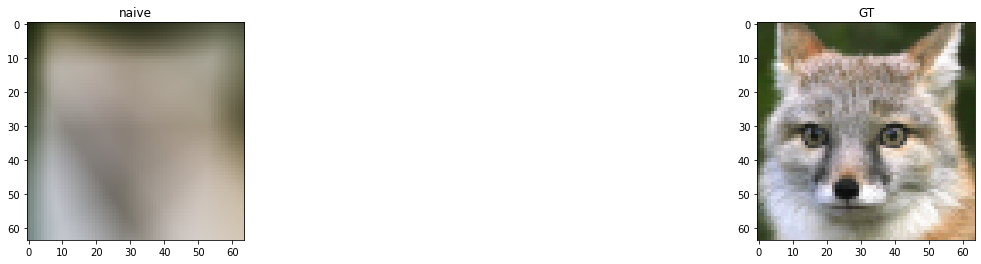

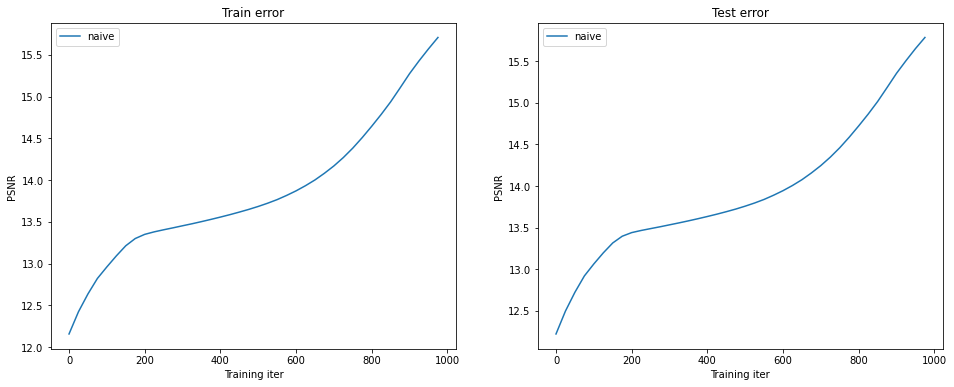

In [14]:
# Show final network outputs

plt.figure(figsize=(24, 4))
N = len(outputs)
for i, k in enumerate(outputs):
    plt.subplot(1, N+1, i+1)
    plt.imshow(outputs[k]['pred_imgs'][-1])
    plt.title(k)
plt.subplot(1, N+1, N+1)
plt.imshow(img)
plt.title('GT')
plt.show()

# Plot train/test error curves

plt.figure(figsize=(16, 6))

plt.subplot(121)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
plt.title('Train error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.subplot(122)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
plt.title('Test error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.show()

# Positional encoding

We need a better way to represent the input coordinates! 

Currently we use no mapping (naive): $\gamma(\mathbf{v})= \mathbf{v}$. 

We need a better way to represent the input coordinates. 

We can use a positional encoding: $\gamma(\mathbf{v})=\left[ \ldots, \cos(2^{j} \mathbf{v}),\sin(2^{j} \mathbf{v}), \ldots \right]^\mathrm{T}$ for $j = 0, \ldots, L-1$. 


### ⌨️ Try it yourself: Use a positional encoding!

Use a positional encoding to represent the input coordinates and train the model again.
You can use the function `posenc` below.
What is a good value for `L`?

In [15]:
def posenc(x, L_embed=6):
  rets = [x]
  for i in range(L_embed):
    for fn in [np.sin, np.cos]:
      rets.append(fn(2.**i * x))
  return np.concatenate(rets, axis=-1)



B_dict = {}

# Positional mapping
for _l in [2, 6, 24]:
  B_dict[f'L={_l}'] = lambda x, l=_l: posenc(x, l)

# This should take about 2-3 minutes
for k in B_dict:
  outputs[k] = train_model(network_size, learning_rate, iters,  train_data, test_data, B_dict[k])

## Plot results

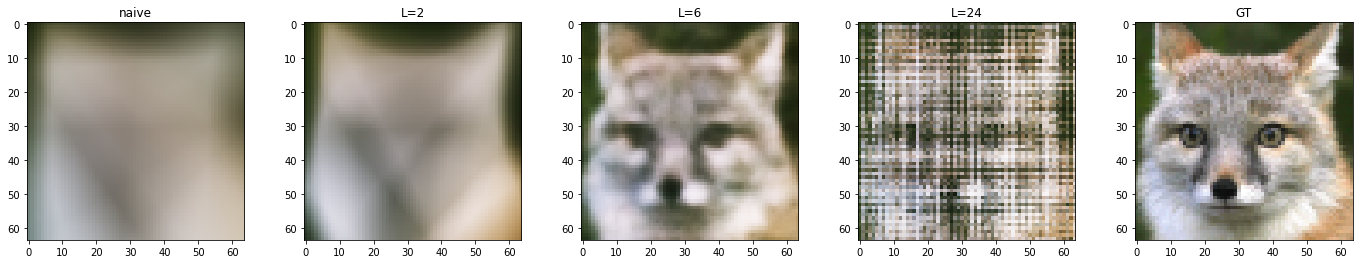

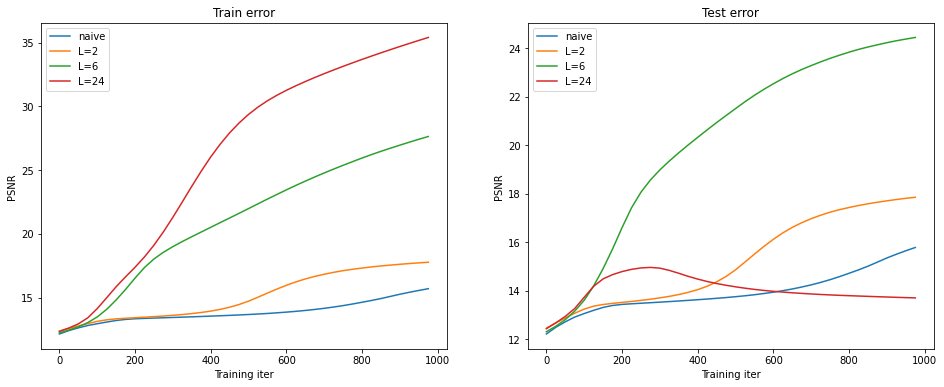

In [16]:
# Show final network outputs

plt.figure(figsize=(24, 4))
N = len(outputs)
for i, k in enumerate(outputs):
    plt.subplot(1, N+1, i+1)
    plt.imshow(outputs[k]['pred_imgs'][-1])
    plt.title(k)
plt.subplot(1, N+1, N+1)
plt.imshow(img)
plt.title('GT')
plt.show()

# Plot train/test error curves

plt.figure(figsize=(16, 6))

plt.subplot(121)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
plt.title('Train error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.subplot(122)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
plt.title('Test error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.show()

# Visualize the training process

While the network was training, we stored the network's predictions every 25th iteration.
Let's visualize it over time. 


In [17]:
# Save out video
all_preds = np.concatenate([outputs[n]['pred_imgs'] for n in outputs], axis=-2)
data8 = (255*np.clip(all_preds, 0, 1)).astype(np.uint8)
f = os.path.join('training_convergence.mp4')
imageio.mimwrite(f, data8, fps=20)

# Display video inline
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'''
<video width=1000 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
</video>
<table width="1000" cellspacing="0" cellpadding="0">
  <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
  <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
</table>
'''.format(*list(outputs.keys())))

,,,
naive,L=2,L=6,L=24
